Take the data from the two sessions and simply treat it as one whole dataset. Hopefully, it will really work as one dataset.

In [1]:
%matplotlib inline
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from matplotlib.ticker import StrMethodFormatter

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             accuracy_score,
                             f1_score)
from sklearn.model_selection import (cross_val_predict, 
                                     cross_val_score, 
                                     GridSearchCV, 
                                     StratifiedKFold, 
                                     StratifiedShuffleSplit,
                                     train_test_split)
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve, learning_curve

In [3]:
def plot_bin_scores(scores, ax):
    gb = scores.groupby(by="bin", as_index=False)
    scores_mean = gb.mean()["acc"]
    scores_std = gb.std()["acc"]
    num_bins = len(scores_mean)
    x = np.arange(num_bins)
    ax.plot(x, scores_mean)
    ax.fill_between(x, scores_mean - scores_std, 
                    scores_mean + scores_std, alpha=0.15)
    ax.set_xlabel('Bin number')
    ax.set_ylabel('Accuracy')
    ax.grid()
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
    return ax, scores_mean

In [4]:
!ls data/visual

old_s1	p22_bins20ms  p24_20ms	   p27	     p27_movcorr
p22	p24	      p24_movcorr  p27_20ms


In [5]:
n_jobs = 10

# Concatenate sessions

In [6]:
participant = 'p24_movcorr'
n_trials = 79 * 2 # because we concatenate two sessions

In [7]:
ve0_file = sorted(glob('data/visual/{}*/VE0*'.format(participant)))
ve1_file = sorted(glob('data/visual/{}*/VE1*'.format(participant)))

In [8]:
def read_ve(ve_file):
    ve = pd.read_csv(ve_file, header=None).transpose()
    new_header = ve.iloc[0]
    ve = ve[1:]
    ve.columns = new_header
    # 'EOG002', 'EOG003', 
    ve = ve.drop(['EOG002', 'EOG003', 'STI016', 'STI101', 'STI102', 'SYS101', 'SYS201', 
                    'CHPI001', 'CHPI002', 'CHPI003', 'CHPI004', 'CHPI005',
                    'CHPI006', 'CHPI007', 'CHPI008', 'CHPI009'],
                    axis=1)
    ve = ve.apply(pd.to_numeric, errors='ignore')    
    return ve

In [9]:
ve0 = pd.concat([read_ve(ve) for ve in ve0_file],
                ignore_index=True)

ve1 = pd.concat([read_ve(ve) for ve in ve1_file],
                ignore_index=True)

In [10]:
bins_per_trial = int(ve0.shape[0] / n_trials)
print(bins_per_trial)

100


A simple visual confirmation that we have two different time series for VE0 and VE1.

In [11]:
plt.plot(ve0.loc[:bins_per_trial, 'MEG0111'], lw=1)
plt.plot(ve0.loc[bins_per_trial:bins_per_trial*2, 'MEG0111'], lw=1)
plt.plot(ve1.loc[:bins_per_trial, 'MEG0111'], lw=1)
plt.plot(ve1.loc[bins_per_trial:bins_per_trial*2, 'MEG0111'], lw=1)

In [12]:
timebin_to_take = 5

In [13]:
# ve0.columns.get_loc("MEG1521")
X_0 = ve0.iloc[:, :].values
X_1 = ve1.iloc[:, :].values

In [14]:
X_0 = X_0.reshape(n_trials, bins_per_trial, -1)
X_1 = X_1.reshape(n_trials, bins_per_trial, -1)
# [trial_number, bin, sensor]
print(X_0.shape)
print(X_1.shape)

(158, 100, 306)
(158, 100, 306)


In [15]:
X = np.vstack((X_0[:, timebin_to_take, :], 
               X_1[:, timebin_to_take, :]))
y = np.repeat([-1, 1], int(X.shape[0] / 2))

In [16]:
pipeline = make_pipeline(MaxAbsScaler(),
                         # PCA(n_components=.99, svd_solver='full'),
                         LogisticRegression(C=1, 
                                            solver='liblinear', 
                                            penalty='l1')
                         )
cvss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
cvsk = StratifiedKFold(n_splits=10, random_state=42)

In [17]:
y_pred = cross_val_predict(pipeline, X, y, cv=cvsk, n_jobs=n_jobs)

In [18]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

         -1       0.55      0.55      0.55       158
          1       0.55      0.54      0.55       158

avg / total       0.55      0.55      0.55       316



In [19]:
print(confusion_matrix(y, y_pred))

[[87 71]
 [72 86]]


We want to identify what is the bin accuracy and which bin is the best.

In [20]:
bin_scores = {}
# bins_per_trial = 0
for b in range(bins_per_trial):
    X = np.vstack((X_0[:, b, :], 
                   X_1[:, b, :]))
    y = np.repeat([-1, 1], int(X.shape[0] / 2))
    this_bin_scores = cross_val_score(pipeline, X, y, cv=cvsk, n_jobs=n_jobs)
    bin_scores[b] = this_bin_scores
#     print('bin {}: {:.3%} ACC'.format(
#           b, np.mean(this_bin_scores)))

In [21]:
scores = pd.melt(pd.DataFrame(bin_scores), var_name="bin", value_name="acc")

In [22]:
sorted_scores = (scores
                 .groupby(by="bin", as_index=False)
                 .mean()
                 .sort_values(by='acc', ascending=False)
                 .head(10)
                )

In [23]:
sorted_scores

bin       acc
36   36  0.766458
32   32  0.765625
37   37  0.750417
33   33  0.714792
34   34  0.689792
35   35  0.677500
30   30  0.676458
41   41  0.655000
29   29  0.653125
31   31  0.648750

In [24]:
best_bin = sorted_scores.bin.iloc[0]

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
ax, score_means = plot_bin_scores(scores, ax)
ax.set_title('Visual - Concatenated Sessions - {}'.format(participant),
             fontsize=14)
ax2 = ax.twiny()
ax2.plot(range(len(score_means)), score_means, alpha=0)
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.1))
# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines["bottom"].set_visible(True)
ax2.set_xticks([0, 20, 100])
ax2.set_xticklabels(["-400ms", "onset", "+1600ms"])
ax.axvline(best_bin, color='grey', ls='--', lw=1)

# Learning curve and validation curve for the concatenated datasets using the best bin.

In [26]:
X = np.vstack((X_0[:, best_bin, :], 
               X_1[:, best_bin, :]))
y = np.repeat([-1, 1], int(X.shape[0] / 2))

In [27]:
# possible_cs = np.logspace(-2, 3, 6)
possible_cs = [1e-3, 1e-2, 1e-1, 1, 5, 10, 50, 1e2, 5e2, 1e3]
possible_cs = np.asarray(possible_cs)
train_scores, valid_scores = validation_curve(pipeline, X, y, 
                                              "logisticregression__C",
                                              possible_cs,
                                              cv=cvss,
                                              n_jobs=n_jobs)

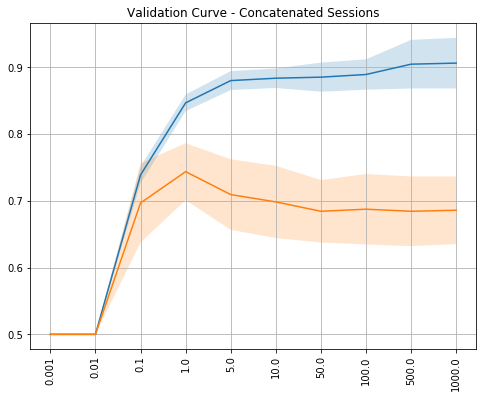

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
mean_train = train_scores.mean(axis=1)
mean_valid = valid_scores.mean(axis=1)
std_train = train_scores.std(axis=1)
std_valid = valid_scores.std(axis=1)
ax.plot(mean_train)
ax.plot(mean_valid)
x = np.arange(mean_train.size)
ax.fill_between(x, mean_train + std_train, mean_train - std_train, alpha=0.2)
ax.fill_between(x, mean_valid + std_valid, mean_valid - std_valid, alpha=0.2)
ax.set_xticks(range(possible_cs.size))
_ = ax.set_xticklabels(possible_cs, rotation=90)
ax.set_title('Validation Curve - Concatenated Sessions')
ax.grid()

In [29]:
train_sizes, train_scores, valid_scores = learning_curve(
    pipeline, 
    X, y, 
    train_sizes=np.linspace(.1, 1., num=10), 
    cv=cvss,
    n_jobs=n_jobs
)

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
valid_mean = valid_scores.mean(axis=1)
valid_std = valid_scores.std(axis=1)
x = range(train_sizes.size)
ax.plot(x, train_mean)
ax.fill_between(x, train_mean + train_std, train_mean - train_std, alpha=0.1)
ax.plot(x, valid_scores.mean(axis=1))
ax.fill_between(x, valid_mean + valid_std, valid_mean - valid_std, alpha=0.1)
ax.set_xticks(x)
_ = ax.set_xticklabels(train_sizes)
ax.set_title('Learning Curve - Concatenated Sessions')
ax.grid()

# Train on one session, test on the other

In [31]:
X_0.shape

(158, 100, 306)

In [32]:
X_0_1 = X_0[int(n_trials / 2):] # first session
X_0_2 = X_0[:int(n_trials / 2)] # second session
X_1_1 = X_1[int(n_trials / 2):]
X_1_2 = X_1[:int(n_trials / 2)]

In [33]:
bin_scores = {}
# bins_per_trial = 0
for b in range(bins_per_trial):
    X_f = np.concatenate((X_0_1[:, b, :], X_1_1[:, b, :]))
    y_f = np.repeat([-1, 1], int(X_f.shape[0] / 2))
    X_s = np.concatenate((X_0_2[:, b, :], X_1_2[:, b, :]))
    y_s = np.repeat([-1, 1], int(X_s.shape[0] / 2))
    pipeline_fit = pipeline.fit(X_f, y_f)
    y_pred = pipeline_fit.predict(X_s)
    this_bin_scores = accuracy_score(y_s, y_pred)
#     this_bin_scores = cross_val_score(gscv, X, y, cv=10)
    bin_scores[b] = [this_bin_scores]
#     print('bin {}: {:.3%} ACC'.format(
#           b, np.mean(this_bin_scores)))

In [34]:
scores = pd.melt(pd.DataFrame(bin_scores), var_name="bin", value_name="acc")

In [35]:
sorted_scores = (scores
                 .groupby(by="bin", as_index=False)
                 .mean()
                 .sort_values(by='acc', ascending=False)
                 .head(10)
                )

In [36]:
sorted_scores

bin       acc
36   36  0.740506
32   32  0.702532
33   33  0.689873
35   35  0.670886
34   34  0.626582
37   37  0.620253
30   30  0.607595
39   39  0.601266
49   49  0.601266
43   43  0.601266

In [37]:
best_bin = sorted_scores.bin.iloc[0]

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))
ax, score_means = plot_bin_scores(scores, ax)
ax.set_title('Training on 1st sess, predict on 2nd',
             fontsize=14)
ax2 = ax.twiny()
ax2.plot(range(len(score_means)), score_means, alpha=0)
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.15))
# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines["bottom"].set_visible(True)
ax2.set_xticks([0, 20, 100])
ax2.set_xticklabels(["-400ms", "onset", "+1600ms"])
ax.axvline(best_bin, color='grey', ls='--', lw=1)

Now, second on first.

In [39]:
bin_scores = {}
# bins_per_trial = 0
for b in range(bins_per_trial):
    X_f = np.concatenate((X_0_1[:, b, :], X_1_1[:, b, :]))
    y_f = np.repeat([-1, 1], int(X_f.shape[0] / 2))
    X_s = np.concatenate((X_0_2[:, b, :], X_1_2[:, b, :]))
    y_s = np.repeat([-1, 1], int(X_s.shape[0] / 2))
    pipeline_fit = pipeline.fit(X_s, y_s)
    y_pred = pipeline_fit.predict(X_f)
    this_bin_scores = accuracy_score(y_f, y_pred)
#     this_bin_scores = cross_val_score(gscv, X, y, cv=10)
    bin_scores[b] = [this_bin_scores]
#     print('bin {}: {:.3%} ACC'.format(
#           b, np.mean(this_bin_scores)))

In [40]:
scores = pd.melt(pd.DataFrame(bin_scores), var_name="bin", value_name="acc")

In [41]:
sorted_scores = (scores
                 .groupby(by="bin", as_index=False)
                 .mean()
                 .sort_values(by='acc', ascending=False)
                 .head(10)
                )

In [42]:
sorted_scores

bin       acc
32   32  0.759494
36   36  0.759494
33   33  0.708861
37   37  0.696203
34   34  0.664557
30   30  0.651899
35   35  0.626582
29   29  0.620253
41   41  0.620253
11   11  0.613924

In [43]:
best_bin = sorted_scores.bin.iloc[0]

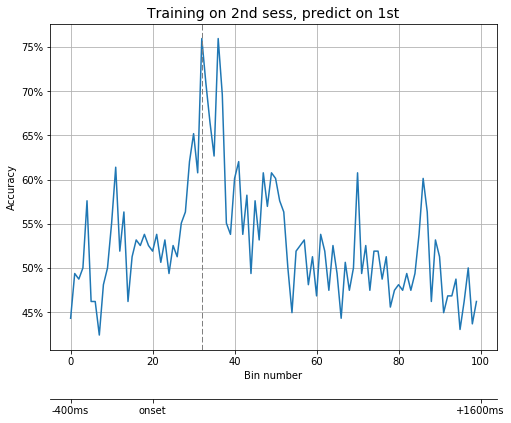

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
ax, score_means = plot_bin_scores(scores, ax)
ax.set_title('Training on 2nd sess, predict on 1st',
             fontsize=14)
ax2 = ax.twiny()
ax2.plot(range(len(score_means)), score_means, alpha=0)
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.15))
# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines["bottom"].set_visible(True)
ax2.set_xticks([0, 20, 100])
ax2.set_xticklabels(["-400ms", "onset", "+1600ms"])
ax.axvline(best_bin, color='grey', ls='--', lw=1)